# 01 – Exploração do Snapshot

Primeiro notebook do **creditlab**.

Nele, vamos:
1. Instanciar o `CreditDataSynthesizer`.
2. Gerar a *safra 0* (snapshot) para alguns grupos homogêneos.
3. Fazer uma exploração inicial: contagem de contratos por grupo, estatísticas descritivas e um histograma de dias em atraso.

⚠️ Este notebook assume que o módulo `credit_data_synthesizer.py` está no mesmo diretório ou em `PYTHONPATH`.

In [1]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt


from importlib import reload
import credit_data_synthesizer as cds
reload(cds)  # garante versão atual no notebook

from credit_data_synthesizer import (
    CreditDataSynthesizer,
    default_group_profiles,   # função helper já incluída no módulo
)

from credit_data_sampler import (
    TargetSampler
)

pd.set_option('display.max_rows', 500)

## Parâmetros iniciais

In [2]:
# from credit_data_synthesizer import CreditDataSynthesizer, default_group_profiles
# from credit_data_sampler import TargetSampler

# # gerar painel com churn dinamico
# synth = CreditDataSynthesizer(
#     group_profiles=default_group_profiles(2),
#     contracts_per_group=1_000,
#     n_safras=12,
#     new_contract_rate=0.05,
#     closure_rate=0.03,
# )
# _, panel, _ = synth.generate()

# # rebalancear bad-rate preservando ranking dos grupos
# sampler = TargetSampler(target_ratio=0.08, preserve_rank=True)
# panel_bal = sampler.fit_transform(panel, target_col="ever90m12", safra_col="safra")
# display(panel_bal.head())

In [3]:
#panel_bal.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [4]:
# ----- parâmetros que você quer -----
YEARS=3
n_groups = 5
contracts_per_group = 500
n_safras = 12*YEARS
seed = 0

# 1) Obtenha os perfis padrão e pegue só os três primeiros
group_profiles = default_group_profiles(n_groups)

# 2) Instancie o sintetizador
synth = CreditDataSynthesizer(
    group_profiles=group_profiles,
    contracts_per_group=contracts_per_group,
    n_safras=n_safras,
    random_seed=0,
    start_safra = 201501,
    target_ratio=0.10,
    new_contract_rate=0.045,
    closure_rate=0.025,
    force_event_rate=False,
    verbose=True
)

## Geração da safra 0

In [5]:
# 3) Gere os dados
df_snapshot, df_panel, df_trace = synth.generate()

print(f"Snapshot gerado com {len(df_snapshot):,} linhas")
print(f"Painel gerado com {len(df_panel):,} linhas")
print(f"Rastro gerado com {len(df_trace):,} linhas")
display(df_snapshot.head())

Snapshot gerado com 2,500 linhas
Painel gerado com 115,186 linhas
Rastro gerado com 4,123 linhas


,id_contrato,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,renda_mensal,tempo_no_endereco_anual,tempo_no_emprego_anual,...,ever360m18,flag_cura,write_off,id_cliente,data_nascimento,sexo,duration_m,age_months,data_fim_contrato,subcluster
0,10000000,GH1,2014-09-30,2015-01-01,201501,30,0,5428.210449,12.221973,6.405475,...,0,0,0,2984.0,1957-12-12,M,48.0,0.0,NaT,14.0
1,10000001,GH1,2014-12-01,2015-01-01,201501,15,0,6329.781738,2.529002,2.979894,...,0,0,0,1200.0,1999-01-12,N,35.0,0.0,NaT,12.0
2,10000002,GH1,2014-11-07,2015-01-01,201501,15,0,3132.432373,0.819627,0.554511,...,0,0,0,701.0,1965-09-25,F,26.0,0.0,NaT,6.0
3,10000003,GH1,2014-10-12,2015-01-01,201501,120,0,4985.072266,8.160900,7.764399,...,0,0,0,4064.0,2002-08-19,M,11.0,0.0,NaT,12.0
4,10000004,GH1,2014-08-18,2015-01-01,201501,15,0,4836.891602,7.852748,2.094030,...,0,0,0,2504.0,1964-07-13,M,16.0,0.0,NaT,10.0


In [6]:
df_panel.columns

Index(['id_contrato', 'grupo_homogeneo', 'data_inicio_contrato', 'data_ref',
       'safra', 'dias_atraso', 'nivel_refinanciamento', 'renda_mensal',
       'tempo_no_endereco_anual', 'tempo_no_emprego_anual', 'num_dependentes',
       'tipo_residencia', 'score_bureau_externo', 'qtd_consultas_bureau_3m',
       'dia_vencimento_parcela', 'tipo_garantia', 'ltv_inicial_pct',
       'renda_liquida_disp_pct', 'prazo_meses', 'taxa_juros_anual_pct',
       'valor_liberado', 'saldo_devedor', 'valor_parcela',
       'num_parcelas_pagas', 'data_ult_pgt', 'num_parcelas_pagas_consecutivas',
       'score_latente', 'qtd_renegociacoes', 'streak_90', 'ever90m12',
       'over90m12', 'ever360m18', 'flag_cura', 'write_off', 'id_cliente',
       'data_nascimento', 'sexo', 'duration_m', 'age_months',
       'data_fim_contrato', 'subcluster'],
      dtype='object')

In [ ]:
flag_cura

In [9]:
print(df_trace.shape)
df_trace.head()

(4123, 3)


,id_antigo,id_novo,data_evento
0,10000003,10002500,2015-02-01
1,10000047,10002501,2015-02-01
2,10000048,10002502,2015-02-01
3,10000064,10002503,2015-02-01
4,10000081,10002504,2015-02-01


In [8]:
print(df_panel.shape)
df_panel.head()

(115186, 41)


,id_contrato,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,renda_mensal,tempo_no_endereco_anual,tempo_no_emprego_anual,...,ever360m18,flag_cura,write_off,id_cliente,data_nascimento,sexo,duration_m,age_months,data_fim_contrato,subcluster
0,10000000,GH1,2014-09-30,2015-01-01,201501,30,0,5428.210449,12.221973,6.405475,...,0,0,0,2984.0,1957-12-12,M,48.0,0.0,NaT,14.0
1,10000001,GH1,2014-12-01,2015-01-01,201501,15,0,6329.781738,2.529002,2.979894,...,0,0,0,1200.0,1999-01-12,N,35.0,0.0,NaT,12.0
2,10000002,GH1,2014-11-07,2015-01-01,201501,15,0,3132.432373,0.819627,0.554511,...,0,0,0,701.0,1965-09-25,F,26.0,0.0,NaT,6.0
3,10000003,GH1,2014-10-12,2015-01-01,201501,120,0,4985.072266,8.160900,7.764399,...,0,0,0,4064.0,2002-08-19,M,11.0,0.0,NaT,12.0
4,10000004,GH1,2014-08-18,2015-01-01,201501,15,0,4836.891602,7.852748,2.094030,...,0,0,0,2504.0,1964-07-13,M,16.0,0.0,NaT,10.0


In [8]:
df_panel[[
    'id_contrato', 'data_inicio_contrato', 
    'data_ref', 'safra', 'dias_atraso'
]].sort_values(['id_contrato', 'data_ref']).reset_index(drop=True).to_parquet(
    'full_history.parquet',
    engine='fastparquet'
)

df_trace.to_parquet(
    'rastro_contratos.parquet',
    engine='fastparquet'
)

In [ ]:
df_panel.columns[df_panel.columns.str.contains('over')]

In [ ]:
df_panel[df_panel.dias_atraso>60]

In [ ]:
df_panel[df_panel['id_contrato']=='10010926'][['safra', 'data_ref','id_contrato','dias_atraso']]

In [ ]:
[['safra', 'data_ref','id_contrato','dias_atraso']]

In [9]:
df_panel[df_panel['id_contrato']=='10000000'][['safra', 'data_ref','id_contrato','dias_atraso']]

#.to_excel('amostra_para_correcao.xlsx')

,safra,data_ref,id_contrato,dias_atraso
0,201501,2015-01-01,10000000,30
2500,201501,2015-02-01,10000000,15
5125,201501,2015-03-01,10000000,15
7828,201501,2015-04-01,10000000,30
10571,201501,2015-05-01,10000000,60
13358,201501,2015-06-01,10000000,90
16187,201501,2015-07-01,10000000,60
19054,201501,2015-08-01,10000000,90
21916,201501,2015-09-01,10000000,90
24778,201501,2015-10-01,10000000,60


In [ ]:
df_panel['safra'].min()#,df_panel['safra'].max()

In [ ]:
df_panel.groupby(['safra','grupo_homogeneo'])['ever90m12'].mean()*100

In [11]:
df_panel[df_panel['safra'].astype(int)>=201601].groupby('grupo_homogeneo')['ever90m12'].mean()*100

grupo_homogeneo
GH1    23.371199
GH2    20.810056
GH3    21.790675
GH4    18.361167
GH5    16.477219
Name: ever90m12, dtype: float64

In [ ]:
df_panel['nivel_refinanciamento'].describe()

In [ ]:
df_snapshot['dias_atraso'].value_counts()

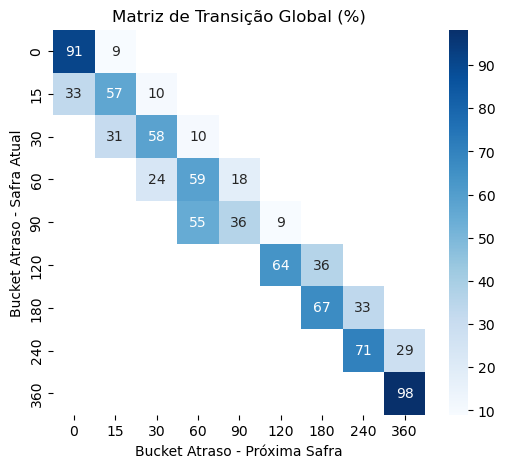

In [12]:
import numpy as np
import importlib
import transition_matrix_estimator

importlib.reload(transition_matrix_estimator)

from transition_matrix_estimator import TransitionMatrixLearner

global_learner = TransitionMatrixLearner(buckets=[0,15,30,60,90,120,180,240,360])
global_learner.fit(
    df_panel,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    group_col='grupo_homogeneo',
)

global_learner.plot_heatmaps(modes=["global"]); #save_dir="figs/")

In [ ]:
import numpy as np
import importlib
import ever_cure_matrix
importlib.reload(ever_cure_matrix)
from ever_cure_matrix import EverCureMatrixLearner

ecm = EverCureMatrixLearner(buckets=[0, 15, 30, 60, 90])

ecm.fit(
    df_panel,
    horizon=12,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    )

ecm.plot_heatmaps()

plt.show()

In [ ]:
# balanceando target
sampler = TargetSampler(target_ratio=0.10)
balanced = sampler.fit_transform(df_panel, target_col="ever90m12")

#prev = balanced.groupby("safra")["ever90m12"].mean()*100
#print("Prev per safra (balanced):")
#print(prev.head())

In [ ]:
df_snapshot.groupby('sexo')['ever90m12'].mean()*100

In [ ]:
df_snapshot.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
balanced.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
len(balanced), len(df_panel)

In [ ]:
balanced['safra'].value_counts()

In [ ]:
balanced.groupby(by='safra', as_index=True)['ever90m12'].mean()*100

### Contagem de contratos por `grupo_homogeneo`

In [ ]:
df_snapshot['grupo_homogeneo'].value_counts()

### Estatísticas descritivas das variáveis numéricas

In [ ]:
cols_numericas = balanced.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    balanced[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

### Distribuição de `dias_atraso`

In [ ]:
plt.figure()
balanced['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [ ]:
df_snapshot.shape